# Embeddings de Alpha Earth a nodos de OSM

El objetivo de este notebook es colapsar los embeddings de alpha earth extraídos en ```AE_embeddings_extraction.ipynb``` a los nodos de Open Street Map. Para esto, se toman todos los embeddings en un radio de *MAX DISTANCE* de cada nodo, y se toma promedio. Ese será el vector de embeddings Alpha Earth asociado a ese nodo.

La metodología es la siguiente: se hace un join entre los DataFrames de puntos de OSM **(poi)** y el dataset de comunas de santiago **(comunas)**. De esta manera, asociamos cada punto de interés a una comuna. Luego 

### imports, lecturas y alineamiento de crs

In [2]:
import numpy as np
import pandas as pd
import geopandas as gpd
import networkx as nx
from sklearn.neighbors import NearestNeighbors

import matplotlib.pyplot as plt
from shapely.geometry import LineString
import re

from utils.utils import networkx_graph_to_gdf, try_int

In [3]:
ae_emb = gpd.read_file("../data/embeddings_alpha_earth.gpkg")
ae_emb = gpd.GeoDataFrame(ae_emb, geometry=gpd.points_from_xy(ae_emb.lon, ae_emb.lat), crs="EPSG:4326")

poi_graph = nx.read_gexf("../data/grafo_OSM/grafo_santiago_filtrado.gexf")
poi = networkx_graph_to_gdf(poi_graph)

comunas = gpd.read_file("../data/comunas_filtradas.gpkg")
comunas = comunas.to_crs("EPSG:4326")

if ae_emb.crs != poi.crs:
    poi = poi.to_crs(ae_emb.crs)
    comunas = comunas.to_crs(ae_emb.crs)

Text(0.5, 0.98, 'Distribución espacial de muestras AlphaEarth y Puntos de Interés OSM en Santiago')

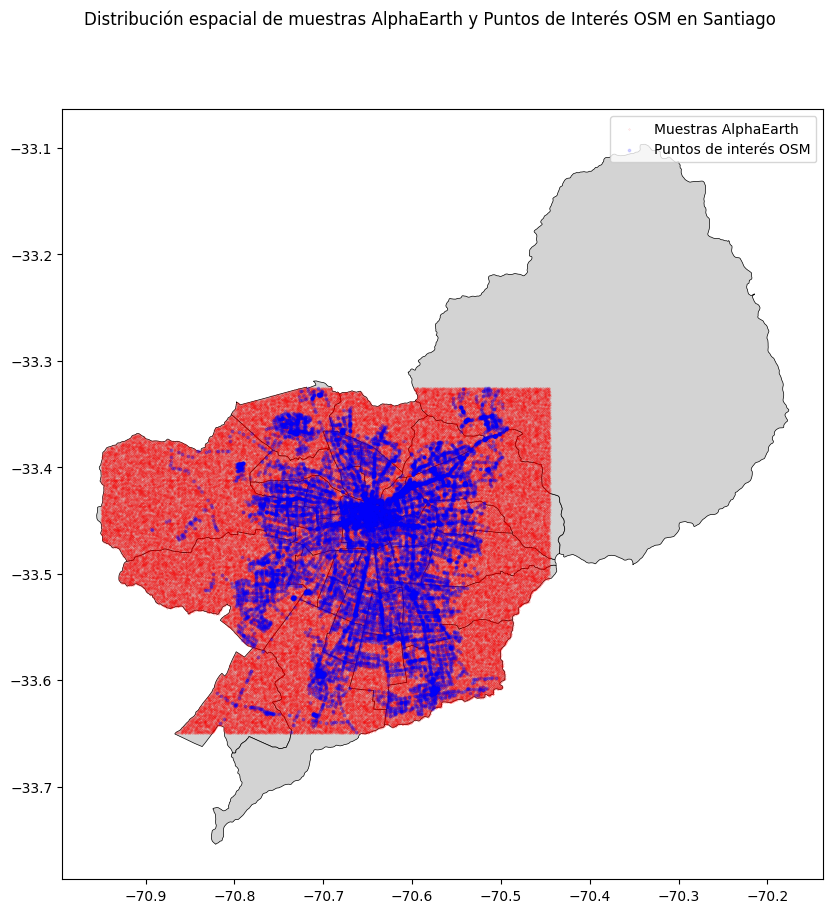

In [3]:
fig, ax = plt.subplots(figsize=(10, 10))
comunas.plot(ax=ax, color="lightgray", edgecolor="black", linewidth=0.5)
ax.scatter(ae_emb.geometry.x, ae_emb.geometry.y, s=.05, alpha=0.3, color="red", label="Muestras AlphaEarth")
ax.scatter(poi.geometry.x, poi.geometry.y, s=3, alpha=0.15, color="blue", label="Puntos de interés OSM")
plt.legend()
plt.suptitle("Distribución espacial de muestras AlphaEarth y Puntos de Interés OSM en Santiago")

### Asignación de embeddings a cada nodo del grafo

In [4]:
MAX_DISTANCE = 200  # Radio de búsqueda en metros para los embeddings
CRS_METRICO = 32719  # UTM zona 19S para Santiago

poi_with_comuna = gpd.sjoin(poi, comunas[["Comuna", "geometry"]], how="left", predicate="within")
poi_with_comuna = poi_with_comuna.to_crs(epsg=CRS_METRICO)
ae_emb = ae_emb.to_crs(epsg=CRS_METRICO)
comunas = comunas.to_crs(epsg=CRS_METRICO)

In [5]:
# Una circunferencia de radio Max Distance alrededor de cada nodo.
poi_buffer = poi_with_comuna.copy()
poi_buffer["geometry"] = poi_buffer.geometry.buffer(MAX_DISTANCE)

# Para cada punto, agrupamos embeddings que estén en la misma comuna. 
matches = []
for comuna, pois_comuna in poi_buffer.groupby("Comuna"):
    ae_comuna = ae_emb[ae_emb["Comuna"] == comuna]
    if ae_comuna.empty or pois_comuna.empty:
        continue

    m = gpd.sjoin(ae_comuna, pois_comuna[["node_id", "Comuna", "geometry"]], how="inner", predicate="within")
    matches.append(m)

matches = pd.concat(matches, ignore_index=True)

In [6]:
matches = matches.rename(columns={"index_right": "poi_index"})
poi_to_embeddings = (
    matches.groupby("node_id").apply(lambda df: df.index.tolist()).reset_index()
)
poi_to_embeddings.columns = ["node_id", "ae_indices"]
poi_enriched = poi.merge(poi_to_embeddings, on="node_id", how="left")

/var/folders/w5/kmvyzkpj2q1fyf7tnn3nqwb40000gn/T/ipykernel_88423/660158064.py:3: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  matches.groupby("node_id").apply(lambda df: df.index.tolist()).reset_index()


In [7]:
sin_embeddings = poi_enriched[
    poi_enriched["ae_indices"].isna() |
    poi_enriched["ae_indices"].apply(lambda x: len(x) == 0 if isinstance(x, list) else False)
]

n_sin_embeddings = len(sin_embeddings)
n_total = len(poi_enriched)

print(f"Nodos sin embeddings asignados: {n_sin_embeddings} de {n_total} ({n_sin_embeddings/n_total:.1%})")
sin_embeddings.head()

Nodos sin embeddings asignados: 0 de 29267 (0.0%)


,node_id,lat,lon,tipo,nombre,geometry,ae_indices


### Visualización de clusters generados

/var/folders/w5/kmvyzkpj2q1fyf7tnn3nqwb40000gn/T/ipykernel_88423/4194781671.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("tab20", n_clusters) if n_clusters <= 20 else plt.cm.get_cmap("hsv", n_clusters)


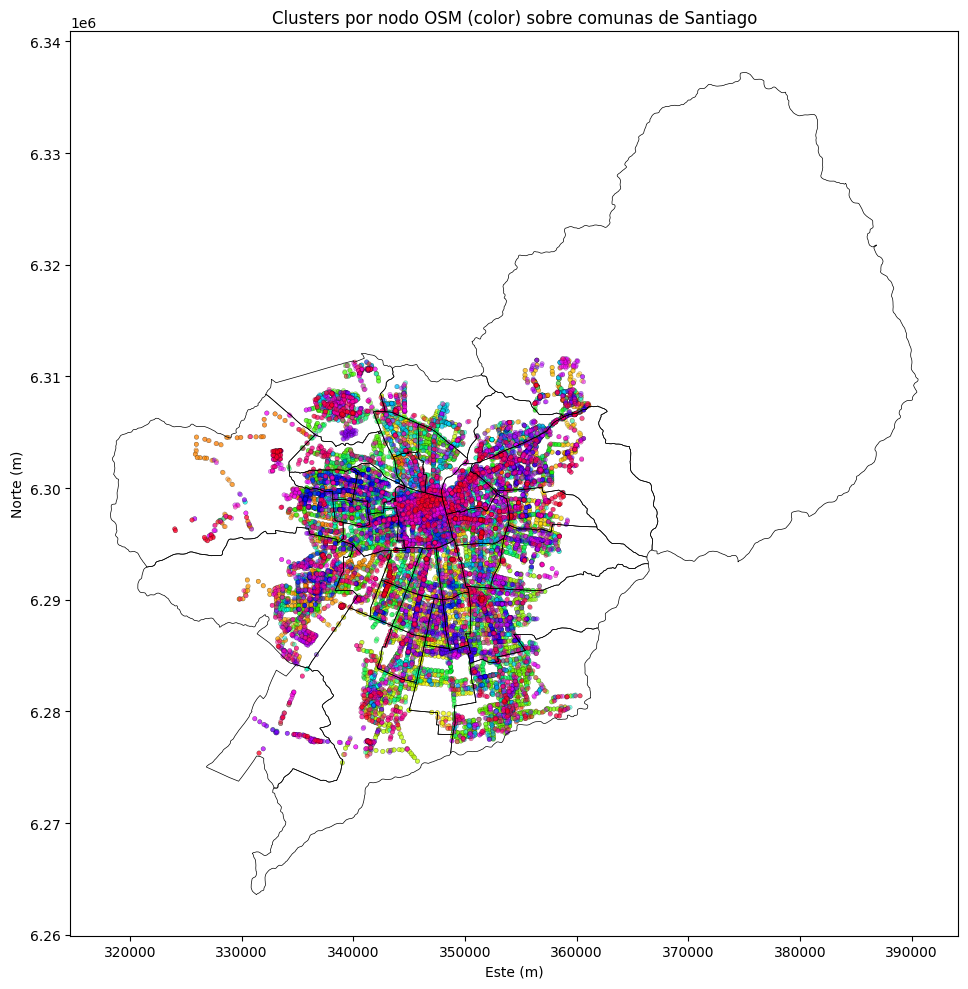

In [8]:
gdf_comunas = comunas.to_crs(epsg=32719)
gdf_poi = poi_enriched.to_crs(epsg=32719)
gdf_poi = gdf_poi.copy()
gdf_poi["cluster_id"] = gdf_poi["node_id"].astype(str)

unique_clusters = gdf_poi["cluster_id"].unique()
n_clusters = len(unique_clusters)

cmap = plt.cm.get_cmap("tab20", n_clusters) if n_clusters <= 20 else plt.cm.get_cmap("hsv", n_clusters)

cluster_to_color = {
    clust: cmap(i) for i, clust in enumerate(unique_clusters)
}

gdf_poi["color"] = gdf_poi["cluster_id"].map(cluster_to_color)

fig, ax = plt.subplots(figsize=(10,10))

gdf_comunas.boundary.plot(ax=ax, linewidth=0.5, edgecolor="black")
gdf_poi.plot(
    ax=ax,
    markersize=10,
    color=gdf_poi["color"],
    alpha=0.5,
    linewidth=0.2,
    edgecolor="black"
)
ax.set_title("Clusters por nodo OSM (color) sobre comunas de Santiago", fontsize=12)
ax.set_xlabel("Este (m)")
ax.set_ylabel("Norte (m)")
ax.set_aspect("equal")

plt.tight_layout()
plt.show()


### Conteo de embeddings por nodo

count    29267.000000
mean        22.796392
std          5.940287
min          1.000000
25%         19.000000
50%         23.000000
75%         26.000000
max         50.000000
Name: n_embeddings, dtype: float64


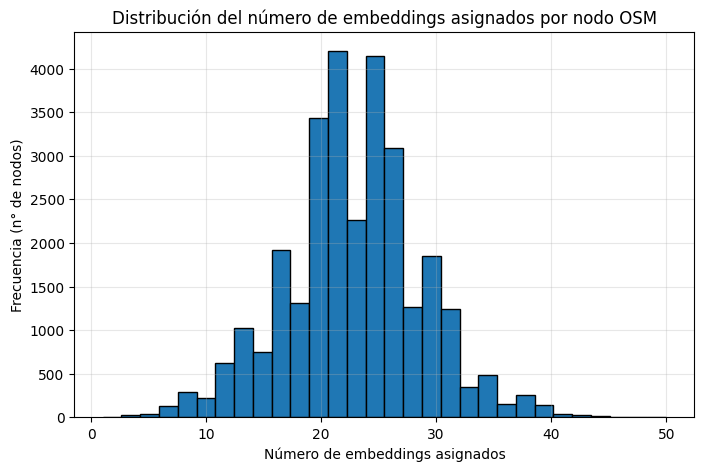

In [9]:
emb_count = matches.groupby("node_id").size().reset_index(name="n_embeddings")
print(emb_count["n_embeddings"].describe())

plt.figure(figsize=(8,5))
plt.hist(emb_count["n_embeddings"], bins=30, edgecolor="black")
plt.title("Distribución del número de embeddings asignados por nodo OSM")
plt.xlabel("Número de embeddings asignados")
plt.ylabel("Frecuencia (n° de nodos)")
plt.grid(alpha=0.3)
plt.show()


### Conversión de Alpha Earth Embeddings a nodos

Se toma promedio de los embeddings asociados a cada nodo.

In [10]:
embedding_cols = [col for col in matches.columns if re.match(r"^A\d+$", col)]
poi_emb_mean = matches.groupby("node_id")[embedding_cols].mean().reset_index()

poi_meta = poi_with_comuna[["node_id", "nombre", "tipo", "Comuna", "lat", "lon", "geometry"
]].drop_duplicates(subset="node_id")

poi_emb_enriched = poi_emb_mean.merge(poi_meta, on="node_id", how="inner")

# Guardar como GPKG. No se guardan aristas, solo nodos y sus respectivos embeddings de Alpha Earth.
poi_emb_enriched_gdf = gpd.GeoDataFrame(poi_emb_enriched, geometry="geometry", crs=poi_with_comuna.crs)
poi_emb_enriched_gdf.to_file("../data/embeddings_AE_for_poi.gpkg", driver="GPKG")

### Construcción de grafo final

In [11]:
# Convertimos id_nodes a int
mapping = {n: try_int(n) for n in list(poi_graph.nodes)}
if any(k != v for k, v in mapping.items()):
    poi_graph = nx.relabel_nodes(poi_graph, mapping, copy=True)
    
poi_nodes = poi_emb_enriched_gdf.copy()
poi_nodes["node_id_norm"] = poi_nodes["node_id"].apply(try_int)
embedding_cols = [c for c in poi_nodes.columns if re.fullmatch(r"A\d+", c)]

def row_to_attrs(row):
    attrs = {
        "nombre": row.get("nombre"),
        "tipo": row.get("tipo"),
        "comuna": row.get("Comuna_poi"),
        "lat": float(row["lat"]) if pd.notnull(row.get("lat")) else None,
        "lon": float(row["lon"]) if pd.notnull(row.get("lon")) else None,
    }
    for c in embedding_cols:
        val = row[c]
        # GEXF admite numéricos; mejor asegurar floats
        if pd.notnull(val):
            attrs[c] = float(val)
    return attrs

attrs_dict = {row["node_id_norm"]: row_to_attrs(row) for _, row in poi_nodes.iterrows()}

In [12]:
# 5) Inyectar atributos a los nodos del grafo
missing_in_graph = []
for nid, attrs in attrs_dict.items():
    if nid in poi_graph:
        poi_graph.nodes[nid].update({k: v for k, v in attrs.items() if v is not None})
    else:
        missing_in_graph.append(nid)

print(f"Nodos con embeddings que NO están en el grafo de aristas: {len(missing_in_graph)}")
nx.write_gexf(poi_graph, "../data/grafo_santiago_filtrado_con_embeddings.gexf")
print("GEXF enriquecido guardado en ../data/grafo_santiago_filtrado_con_embeddings.gexf")

Nodos con embeddings que NO están en el grafo de aristas: 0
GEXF enriquecido guardado en ../data/grafo_santiago_filtrado_con_embeddings.gexf
